In [28]:
import pandas as pd
import re
from random import random
import emoji
from tqdm import notebook
def tqdm(x, **kargs):
    return notebook.tqdm(x, leave=False, **kargs)
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from collections import Counter, defaultdict
import torch
from transformers import BertTokenizer, BertForSequenceClassification, BertForMultipleChoice
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [29]:
# from transformers.modeling_utils import PreTrainedModel
from transformers import BertModel
from torch.nn import BCEWithLogitsLoss, MultiLabelMarginLoss
from transformers.modeling_bert import BertPreTrainedModel

## Data cleaning

In [34]:
# https://github.com/minerva-ml/open-solution-toxic-comments/blob/master/external_data/apostrophes.json
apostrophes = {
  "arent": "are not",
  "cant": "cannot",
  "couldnt": "could not",
  "didnt": "did not",
  "doesnt": "does not",
  "dont": "do not",
  "hadnt": "had not",
  "hasnt": "has not",
  "havent": "have not",
  "hed": "he would",
  "hell": "he will",
  "hes": "he is",
  "id": "I had",
  "ill": "I will",
  "im": "I am",
  "isnt": "is not",
  "its": "it is",
  "itll": "it will",
  "ive": "I have",
  "lets": "let us",
  "mightnt": "might not",
  "mustnt": "must not",
  "shant": "shall not",
  "shed" : "she would",
  "shell": "she will",
  "shes": "she is",
  "shouldnt": "should not",
  "thats": "that is",
  "theres": "there is",
  "theyd": "they would",
  "theyll": "they will",
  "theyre": "they are",
  "theyve": "they have",
  "wed": "we would",
  "were": "we are",
  "werent": "were not",
  "weve": "we have",
  "whatll": "what will",
  "whatre": "what are",
  "whats": "what is",
  "whatve": "what have",
  "wheres": "where is",
  "whod": "who would",
  "wholl": "who will",
  "whore": "who are",
  "whos": "who is",
  "whove": "who have",
  "wont": "will not",
  "wouldnt": "would not",
  "youd": "you would",
  "youll": "you will",
  "youre": "you are",
  "youve": "you have",
  "re":  "are",
  "wasnt": "was not",
  "well":  "will"
}

In [68]:
# https://github.com/minerva-ml/open-solution-toxic-comments/blob/master/external_data/compiled_bad_words.txt
compiled_bad_list = pd.read_csv('https://raw.githubusercontent.com/minerva-ml/open-solution-toxic-comments/master/external_data/compiled_bad_words.txt', header=None)
compiled_bad_list = list(compiled_bad_list[0].values)

In [69]:
# From https://github.com/kaymal/twitter-emotions/blob/master/data-preprocessing.ipynb
def preprocess_tweet(tweet):
    # To lowercase (not good for VADER)
    tweet = tweet.lower()
    
    for bad_word in compiled_bad_list:
        bad_candidate = ' ' + bad_word + ' '
        tweet = tweet.replace(bad_candidate, ' ')
        
    # Replace emoji unicode to text
#     tweet = emoji.demojize(tweet)
#     tweet = tweet.replace('_', ' ')
#     tweet = tweet.replace(':', ' ')
    tweet = tweet.encode('ascii', 'ignore').decode('ascii')    
    # Remove punctuation
    tweet = tweet.replace('.', ' ')
    tweet = tweet.replace(',', ' ')
    
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    
    # Replace apostrophes to original term
    for key in apostrophes.keys():
        tweet = tweet.replace(key, apostrophes[key])
    
    #Convert @username to "user"
    tweet = re.sub('@[^\s]+', 'user', tweet)
    
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    
#     # Remove single space remaining at the front of the tweet.
#     tweet = tweet.lstrip(' ')
    
#     # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
#     tweet = ''.join(c for c in tweet if c <= '\uFFFF')
    
#     # Convert hyperlinks ->>>> For now just replace with http
#     tweet = re.sub(r'https?:\/\/.*\/\w*', 'http', tweet)

#     #Remove @user
#     tweet = re.sub('@[^\s]+','',tweet)
    
#     # Remove tickers such as USD ($)
#     tweet = re.sub(r'\$\w*', '', tweet)
    
#     # Remove hashtags (not good for VADER)
#     tweet = re.sub(r'#\w*', '', tweet)
    
#     # Remove Punctuation and split 's, 't, 've with a space for filter
#     tweet = re.sub(r'[' + punctuation.replace('@', '') + ']+', ' ', tweet)
    
#     # Remove words with 2 or fewer letters
#     tweet = re.sub(r'\b\w{1,2}\b', '', tweet)

    return tweet

In [70]:
df = pd.read_json('./source/train_gold.json', lines=True)
df['text'] = df.text.apply(preprocess_tweet)
df['reply'] = df.reply.apply(preprocess_tweet)

In [71]:
print(df['text'][173])
print(df['reply'][3])

a toxic fav line is i just be chI willing like no tf you do not 



In [72]:
categories_type = pd.read_json('./source/categories.json', lines=True)
categories_mapping = {v[0]: k for k, v in categories_type.to_dict('list').items()}

## Multilabel classification of BERT

In [75]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification. This module is composed of the BERT model with a linear layer on top of the pooled output. """ 
    def __init__(self, config, num_labels=43):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
#         self.dropout = torch.nn.Dropout(0.4)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self._init_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False

    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True

## Preprocessing json

In [76]:
# https://github.com/jiesutd/pytorch-pretrained-BERT/blob/master/examples/lm_finetuning/pregenerate_training_data.py
def truncate_seq_pair(tokens_a, tokens_b, max_num_tokens):
    """Truncates a pair of sequences to a maximum sequence length. Lifted from Google's BERT repo."""
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_num_tokens:
            break

        trunc_tokens = tokens_a if len(tokens_a) > len(tokens_b) else tokens_b
        assert len(trunc_tokens) >= 1

        # We want to sometimes truncate from the front and sometimes from the
        # back to add more randomness and avoid biases.
        if random() < 0.5:
            del trunc_tokens[0]
        else:
            trunc_tokens.pop()

In [77]:
class Preprocess():
    def __init__(self, epochs=6, batch_size=64, categories=None):
        self.label = categories
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(categories), output_hidden_states=False)
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#         self.tokenizer = TweetTokenizer()
    
    def tokenize(self, sentance):
        return self.tokenizer.tokenize(sentance)
    
    def convert_features_to_tensors(self, corpus_text, corpus_reply, corpus_class):
        df_tokenize = []
        for sid, sentance in enumerate(corpus_text):
            sentance_reply = corpus_reply[sid]
            token_sentance = self.tokenize(sentance)
            token_reply = self.tokenize(sentance_reply)
            
            # Since max length will > max_seq_length, need to truncate pairs
            truncate_seq_pair(token_sentance, token_reply, max_seq_length - 3)
            
            first_sentance = ['[CLS]'] + token_sentance + ['[SEP]']
            second_sentance = token_reply + ['[SEP]']
            tokens = self.tokenizer.convert_tokens_to_ids(first_sentance + second_sentance)
            len_first = len(first_sentance)
            len_second = len(second_sentance)
            tokens_tensor = torch.tensor(tokens)
            segments_tensor = torch.tensor([0] * len_first + [1] * len_second, dtype=torch.long)
            # Convert label to one hot encoding
            label_onehot_tensor = torch.zeros([len(self.label)])
            for each_class in corpus_class[sid]:
                label_onehot_tensor[self.label[each_class]] = 1
            df_tokenize.append([tokens_tensor, segments_tensor, label_onehot_tensor])
        return df_tokenize
    
    def create_mini_batch(self, corpus):
        tokens_tensors = [sentance[0] for sentance in corpus]
        segments_tensors = [sentance[1] for sentance in corpus]
        labels_tensors = torch.stack([sentance[2] for sentance in corpus])
#         labels_tensors = labels_tensors.type(torch.LongTensor)
        # zero padding
        tokens_tensors = torch.nn.utils.rnn.pad_sequence(tokens_tensors, batch_first=True)
        segments_tensors = torch.nn.utils.rnn.pad_sequence(segments_tensors, batch_first=True)
        # attention masks to set non-zero padding position to one to let BERT focus on these tokens
        masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
        masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
        return tokens_tensors, segments_tensors, masks_tensors, labels_tensors
    
    def train(self, training_data):
        # let model training on GPU
#         device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        device = torch.device("cpu")
        print("device:", device)
        # Load pretrained model
#         model_state_dict = torch.load('./models/bert_adam_4_2_0.331')
#         self.model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(self.label), state_dict=model_state_dict)
        self.model = self.model.to(device)
        # training mode
        self.model.train()
        # select adam as optimizer to update weights
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-5)
        
        for epoch in range(self.epochs):
            running_loss = 0
            for data in tqdm(training_data, desc='Training progress: '):
                tokens_tensors, segments_tensors, masks_tensors, labels = [t.to(device) for t in data]
                # Initial gradients
                optimizer.zero_grad()
                # forward pass
                outputs = self.model(input_ids=tokens_tensors, 
                                token_type_ids=segments_tensors, 
                                attention_mask=masks_tensors, 
                                labels=labels)
                loss = outputs
                # backward
                loss.backward()
                optimizer.step()
                # Record current batch loss
                running_loss += loss.item()
            print("Epoch: {}, loss: {}".format(epoch + 1, running_loss))
        torch.save(self.model.state_dict(), './models/bert_adam_{}_{}'.format(self.epochs, self.batch_size))
        # Calculate classification accuracy
#         _, acc = self.get_predictions(model, training_data, True)
        return self.model
    
    def baseline(self, corpus_text, corpus_reply, corpus_class):
        df_tokenize = self.convert_features_to_tensors(corpus_text, corpus_reply, corpus_class)
        train_loader = torch.utils.data.DataLoader(df_tokenize, batch_size=self.batch_size, collate_fn=self.create_mini_batch)
        tuned_model = self.train(train_loader)
        return tuned_model

In [78]:
max_seq_length = 512
preprocess_module = Preprocess(epochs=3, batch_size=32, categories=categories_mapping)
tuned_model = preprocess_module.baseline(df['text'], df['reply'], df['categories'])

I0525 17:33:28.716817 139714465597248 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ino/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0525 17:33:28.717755 139714465597248 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17"

device: cpu


Epoch: 1, loss: 52.024781197309494


Epoch: 2, loss: 25.68275313079357


Epoch: 3, loss: 19.717267021536827


In [99]:
# torch.save(tuned_model.state_dict(), 'test_bert')
# # Load a trained model that you have fine-tuned
# model_state_dict = torch.load(output_model_file)
# model = BertForMultiLabelSequenceClassification.from_pretrained(args['bert_model'], num_labels = num_labels, state_dict=model_state_dict)

## Get trained model

In [187]:
model_state_dict = torch.load('./models/bert_adam_1_2')
model = BertForMultiLabelSequenceClassification.from_pretrained("bert-base-uncased", num_labels=43, state_dict=model_state_dict)
model.config

I0525 13:15:12.954169 140193940277056 configuration_utils.py:285] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ino/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
I0525 13:15:12.959110 140193940277056 configuration_utils.py:321] Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17"

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31",
    "32": "LABEL_32",
    "33": "LABEL_33",
    "34": "LABEL_34",
    "35": "LABEL_35",
    "36": "LABEL_36",
    "37": "LAB

In [79]:
df_tokenize = []
for sid, sentance in enumerate(df['text']):
    sentance_reply = df['reply'][sid]
    token_sentance = preprocess_module.tokenize(sentance)
    token_reply = preprocess_module.tokenize(sentance_reply)
    
    # Since max length will > max_seq_length, need to truncate pairs
    truncate_seq_pair(token_sentance, token_reply, max_seq_length - 3)
    
    first_sentance = ['[CLS]'] + token_sentance + ['[SEP]']
    second_sentance = token_reply + ['[SEP]']
    tokens = preprocess_module.tokenizer.convert_tokens_to_ids(first_sentance + second_sentance)
    len_first = len(first_sentance)
    len_second = len(second_sentance)
    tokens_tensor = torch.tensor(tokens)
    segments_tensor = torch.tensor([0] * len_first + [1] * len_second, dtype=torch.long)
    # Convert label to one hot encoding
    label_onehot_tensor = torch.zeros([len(preprocess_module.label)])
    for each_class in df['categories'][sid]:
        label_onehot_tensor[preprocess_module.label[each_class]] = 1
    df_tokenize.append([tokens_tensor, segments_tensor, label_onehot_tensor])
train_loader = torch.utils.data.DataLoader(df_tokenize, batch_size=preprocess_module.batch_size, collate_fn=preprocess_module.create_mini_batch)

In [80]:
categories_mapping

{'agree': 0,
 'applause': 1,
 'awww': 2,
 'dance': 3,
 'deal_with_it': 4,
 'do_not_want': 5,
 'eww': 6,
 'eye_roll': 7,
 'facepalm': 8,
 'fist_bump': 9,
 'good_luck': 10,
 'happy_dance': 11,
 'hearts': 12,
 'high_five': 13,
 'hug': 14,
 'idk': 15,
 'kiss': 16,
 'mic_drop': 17,
 'no': 18,
 'oh_snap': 19,
 'ok': 20,
 'omg': 21,
 'oops': 22,
 'please': 23,
 'popcorn': 24,
 'scared': 25,
 'seriously': 26,
 'shocked': 27,
 'shrug': 28,
 'sigh': 29,
 'slow_clap': 30,
 'smh': 31,
 'sorry': 32,
 'thank_you': 33,
 'thumbs_down': 34,
 'thumbs_up': 35,
 'want': 36,
 'win': 37,
 'wink': 38,
 'yawn': 39,
 'yes': 40,
 'yolo': 41,
 'you_got_this': 42}

In [81]:
def get_predictions(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    
    avg_map = 0
    total_predict = []

    with torch.no_grad():
        # Traverse all batches
        for data in tqdm(dataloader, desc='Prediction progress: '):
            # Move tensors to GPU if we can
            if next(model.parameters()).is_cuda:
                data = [t.to("cpu") for t in data if t is not None]
#                 data = [t.to("cuda:0") for t in data if t is not None]


            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)

            logits = outputs
            
            logits = logits.sigmoid()
            
            sorted_logits, sorted_index = torch.sort(logits.data, descending=True)
            
            for eid, each_predict in enumerate(sorted_index.detach().numpy()):
#             for eid, each_predict in enumerate(sorted_index.cpu().detach().numpy()):
                predict_class = []
                correct = 0
                for key, value in categories_mapping.items():
                    if value in each_predict[0:6]:
                        if key == df['categories'][eid][0] and compute_acc is True:
                            correct += 1
                        predict_class.append(key)
                avg_map += (correct / len(df['categories'][eid]))
                
#                 print("answer = {}".format(df['categories'][eid]))
#                 print("predict = {}".format(predict_class))
#                 print("each map = {}".format(correct / len(df['categories'][eid])))
                total_predict.append(predict_class)

    avg_map /= len(df['categories'])
    print("avg map = {}".format(avg_map))

    if compute_acc:
        return total_predict, avg_map
    return total_predict

In [82]:
_, acc = get_predictions(tuned_model, train_loader, True)

avg map = 0.3349322916666672


In [83]:
df_dev = pd.read_json('./source/dev_unlabeled.json', lines=True)
df_dev_result = df_dev.copy()
df_dev['text'] = df.text.apply(preprocess_tweet)
df_dev['reply'] = df.reply.apply(preprocess_tweet)

In [84]:
def create_mini_batch_dev(corpus):
    tokens_tensors = [sentance[0] for sentance in corpus]
    segments_tensors = [sentance[1] for sentance in corpus]
    # zero padding
    tokens_tensors = torch.nn.utils.rnn.pad_sequence(tokens_tensors, batch_first=True)
    segments_tensors = torch.nn.utils.rnn.pad_sequence(segments_tensors, batch_first=True)
    # attention masks to set non-zero padding position to one to let BERT focus on these tokens
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    return tokens_tensors, segments_tensors, masks_tensors

In [85]:
df_dev_tokenize = []
for sid, sentance in enumerate(df_dev['text']):
    sentance_reply = df['reply'][sid]
    token_sentance = preprocess_module.tokenize(sentance)
    token_reply = preprocess_module.tokenize(sentance_reply)
    
    # Since max length will > max_seq_length, need to truncate pairs
    truncate_seq_pair(token_sentance, token_reply, max_seq_length - 3)
    
    first_sentance = ['[CLS]'] + token_sentance + ['[SEP]']
    second_sentance = token_reply + ['[SEP]']
    tokens = preprocess_module.tokenizer.convert_tokens_to_ids(first_sentance + second_sentance)
    len_first = len(first_sentance)
    len_second = len(second_sentance)
    tokens_tensor = torch.tensor(tokens)
    segments_tensor = torch.tensor([0] * len_first + [1] * len_second, dtype=torch.long)

    df_dev_tokenize.append([tokens_tensor, segments_tensor])
dev_loader = torch.utils.data.DataLoader(df_dev_tokenize, batch_size=preprocess_module.batch_size, collate_fn=create_mini_batch_dev)

In [86]:
def get_predictions_dev(model, dataloader, compute_acc=False):
    predictions = None
    correct = 0
    total = 0
    
    avg_map = 0
    total_predict = []

    with torch.no_grad():
        # 遍巡整個資料集
        for data in tqdm(dataloader, desc='Prediction progress: '):
            # 將所有 tensors 移到 GPU 上
            if next(model.parameters()).is_cuda:
#                 data = [t.to("cpu") for t in data if t is not None]
                data = [t.to("cuda:0") for t in data if t is not None]


            # 別忘記前 3 個 tensors 分別為 tokens, segments 以及 masks
            # 且強烈建議在將這些 tensors 丟入 `model` 時指定對應的參數名稱
            tokens_tensors, segments_tensors, masks_tensors = data[:3]
            outputs = model(input_ids=tokens_tensors, 
                            token_type_ids=segments_tensors, 
                            attention_mask=masks_tensors)

            logits = outputs
            
            logits = logits.sigmoid()
            
            sorted_logits, sorted_index = torch.sort(logits.data, descending=True)
            
#             for eid, each_predict in enumerate(sorted_index.detach().numpy()):
            for eid, each_predict in enumerate(sorted_index.cpu().detach().numpy()):
                predict_class = []
                for key, value in categories_mapping.items():
                    if value in each_predict[0:6]:
                        predict_class.append(key)
                total_predict.append(predict_class)
    return total_predict

In [87]:
dev_predictions = get_predictions_dev(tuned_model, dev_loader, False)

In [88]:
df_dev_result['categories'] = dev_predictions

In [89]:
df_dev_result

,idx,text,reply,categories
0,32000,"Drop your cash app, use hashtag #BailoutHumansNow",$tyratomaro #BailoutHumans,"[agree, applause, facepalm, hug, omg, smh]"
1,32001,After interviewing with a few incredible peopl...,CONGRATS!!!!!,"[agree, applause, hug, shocked, smh, yes]"
2,32002,I know GTC festival not happening next month b...,,"[applause, facepalm, hug, no, oops, yes]"
3,32003,"Lordy, my daughter just said, “I wonder how th...",,"[agree, applause, hug, seriously, smh, yes]"
4,32004,THE UNEMPLOYMENT CLAIM SYSTEM SUCKS SO MUCH DICK,Watching everyone else get their weekly unempl...,"[agree, applause, do_not_want, hug, smh, yes]"
...,...,...,...,...
3995,35995,WHY TF DO LOCALS LIKE USING GIFS SO MUCH THEYR...,,"[agree, applause, facepalm, hug, no, yes]"
3996,35996,Choose a gif that best describes the Republica...,,"[agree, applause, hug, omg, smh, yes]"
3997,35997,fuck soon,When soon,"[agree, applause, facepalm, hug, smh, yes]"
3998,35998,SOMEBODY GIVE ME A HUG PLEASE \n\nI would real...,I hope you’re doing okay or will be okay!! Sen...,"[agree, applause, facepalm, hug, thank_you, yes]"


In [90]:
df_dev_result.to_json('./results/dev.json', orient='records', lines=True)

In [15]:
# Only for testing successful running
tokens_tensors, segments_tensors, \
    masks_tensors, label_ids = next(iter(train_loader))
print(f"""
tokens_tensors.shape   = {tokens_tensors.shape} 
{tokens_tensors}
------------------------
segments_tensors.shape = {segments_tensors.shape}
{segments_tensors}
------------------------
masks_tensors.shape    = {masks_tensors.shape}
{masks_tensors}
------------------------
{label_ids}
""")


tokens_tensors.shape   = torch.Size([128, 145]) 
tensor([[  101,  2057,  2064,  ...,     0,     0,     0],
        [  101,  2097,  2017,  ...,     0,     0,     0],
        [  101,  3652,  2039,  ...,     0,     0,     0],
        ...,
        [  101, 16392,  2007,  ...,     0,     0,     0],
        [  101,  1045,  2165,  ...,     0,     0,     0],
        [  101,  1030,  5795,  ...,     0,     0,     0]])
------------------------
segments_tensors.shape = torch.Size([128, 145])
tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
------------------------
masks_tensors.shape    = torch.Size([128, 145])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
------

In [27]:
torch.cuda.empty_cache()

Text(0.5, 1.0, 'Emotions Unnormalized')

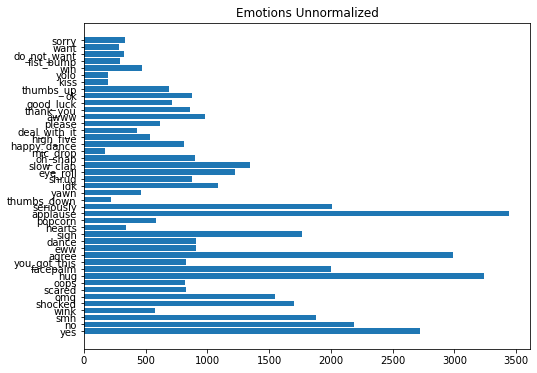

In [6]:
# Visualization of training classes
categories_dict = defaultdict(lambda: 0)
for i in range(len(df)):
    for each_category in df['categories'][i]:
        categories_dict[each_category] += 1
plt.figure(figsize=(8, 6))
plt.barh(list(categories_dict.keys()), categories_dict.values())
plt.title('Emotions Unnormalized')